# Water consumption

The current notebook computes an interpolation of temperatures in each pixel based on SIAM extracted data.

A .bluemix/cos_credentials.json file correctly configured located at home directory is needed in order to connect with IBM Cloud. More information at https://cloud.ibm.com/docs/services/cloud-object-storage/iam?topic=cloud-object-storage-service-credentials.

In [1]:
from collections import defaultdict
from ibm_botocore.client import Config, ClientError
from io_utils.cos import COS
from io_utils.plot import plot_random_blocks, plot_results
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from shapely.geometry import Point, MultiPoint, box

import os
import ibm_boto3
import math
import numpy as np
import pandas as pd
import lithops
import requests
import rasterio
import json

from lithops.storage import Storage

## Global parameters

Area outside the processed tile that we want to consider for taking SIAM stations into account:

In [2]:
AREA_OF_INFLUENCE = 4000

IBM Cos bucket to upload files:

In [3]:
BUCKET = 'aitor-us-south-lite'

Split tile into SPLITS$^2$ chunks:

In [4]:
SPLITS = 3

Correlation coefficient between elevation and temperature:

In [5]:
r = -0.0056

Elevation to interpolate temperature:

In [6]:
zdet = 2000

Day of year to calculate solar irradiation:

In [7]:
DAY_OF_YEAR = 50

## Data preparation

Download SIAM data:

In [ ]:
url = 'http://siam.imida.es/apex/f?p=101:47:493289053024037:CSV::::'
# url = 'http://siam.imida.es/apex/f?p=101:48:2555846978143339:CSV::::'
siam_data = requests.get(url)
with open('siam_data.csv', 'wb') as siam_data_file:
    siam_data_file.write(siam_data.content)

In [ ]:
def guess_nearest(x, y, field, stations):
    '''
    Compute field value at a given x,y point by getting the value of the closest station 
    '''
    from shapely.ops import nearest_points
    stations_of_interest = stations[(stations[field] != '-') & ((stations['X'] != x) | (stations['Y'] != y))]
    points = MultiPoint(stations_of_interest.apply(lambda row: Point(row['X'], row['Y']), axis=1 ).array)
    nearest = nearest_points(Point(x,y), points)[1]
    val = stations_of_interest[(stations_of_interest['X'] == nearest.x) &
                                (stations_of_interest['Y'] == nearest.y)]

    return stations_of_interest[(stations_of_interest['X'] == nearest.x) &
                                (stations_of_interest['Y'] == nearest.y)][field].iloc[0] 

Append locations of SIAM stations to previously downloaded data and write results to a CSV:

In [ ]:
columns = {
    'Estación': 'COD',
    'Tmed <br> (ºC)': 'temp',
    'Hrmed <br> (%)': 'hr',
    'Vvmed <br> (m/seg)': 'v',
    'Eti.': 'dir',
    'Radmed <br> (w/m2)': 'rad',
    'Dvmed <br>  (º)': 'dir_deg'
}

siam_data = pd.read_csv('siam_data.csv', encoding='iso-8859-1',
                        sep=';', decimal=',', thousands='.', na_values = '-')
siam_data = siam_data[columns.keys()].rename(columns=columns)
siam_locations = pd.read_csv('siam_locations.csv', encoding='iso-8859-1', sep=';', decimal = ',', thousands='.')
siam = pd.merge(siam_locations, siam_data, on='COD')
siam['tdet'] = siam['temp'] + r * (zdet - siam['Cota'].to_numpy())
siam = siam[['X', 'Y', 'Cota', 'temp', 'hr', 'tdet', 'v'] + list(columns.values())]
# Guess wind direction of undefined values
siam['dir_deg'] = siam.apply(lambda row: row['dir_deg'] 
                                     if not math.isnan(row['dir_deg'])
                                     else guess_nearest(row['X'], row['Y'], 'dir_deg', siam), axis=1)
# Guess radiation of undefined values
siam['rad'] = siam.apply(lambda row: row['rad'] 
                                     if not math.isnan(row['rad'])
                                     else guess_nearest(row['X'], row['Y'], 'rad', siam), axis=1)
siam.to_csv('siam_out.csv', index=False)

Upload the output CSV cloud object storage:

In [19]:
cloud_storage = Storage()

2021-01-08 10:10:05,773 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-south


In [ ]:
with open('siam_out.csv', 'rb') as siam_out_file:
    cloud_storage.put_object(bucket=BUCKET, key='siam_out.csv', body=siam_out_file)

Download MDT files for free from http://centrodedescargas.cnig.es/CentroDescargas/buscadorCatalogo.do?codFamilia=MDT05# and put them in `MDT` folder.

Find downloaded MDTs:

In [8]:
mdts = [os.path.join('MDT', mdt) for mdt in os.listdir('MDT') if mdt.endswith('.asc')]
mdts

['MDT/PNOA_MDT05_ETRS89_HU30_0934_LID.asc']

In [9]:
tiles = [os.path.splitext(os.path.basename(mdt))[0] for mdt in mdts]
tiles

['PNOA_MDT05_ETRS89_HU30_0934_LID']

Convert digital elevation map into a Cloud Optimized Geotiff. Upload then to IBM COS:

In [ ]:
for mdt in mdts:
    tiff_file = os.path.splitext(mdt)[0] + '.tif'
    with rasterio.open(mdt) as src:
        profile = src.profile
        # Cloud optimized GeoTiff parameters (No hace falta rio_cogeo)
        profile.update(driver='GTiff')
        profile.update(blockxsize=256)
        profile.update(blockysize=256)
        profile.update(tiled=True)
        profile.update(compress='deflate')
        profile.update(interleave='band')
        with rasterio.open(tiff_file, "w", **profile) as dest:
            dest.write(src.read())

In [12]:
mdts_gtiff = [os.path.join('MDT', mdt) for mdt in os.listdir('MDT') if mdt.endswith('.tif')]
mdts_gtiff

['MDT/PNOA_MDT05_ETRS89_HU30_0934_LID.tif']

In [ ]:
for mdt_gtiff in mdts_gtiff:
    with open(mdt_gtiff, 'rb') as mdt_file:
        cloud_storage.put_object(bucket=BUCKET, key=mdt_gtiff, body=mdt_file)

## Serverless computation

Compute solar irradiation given a day of year using GRASS libraries:

In [13]:
def compute_solar_irradiation(inputFile, outputFile, crs='32630'):
    # Define grass working set
    GRASS_GISDB = 'grassdata'
    GRASS_LOCATION = 'GEOPROCESSING'
    GRASS_MAPSET = 'PERMANENT'
    GRASS_ELEVATIONS_FILENAME = 'ELEVATIONS'
    
    import os
    import shutil
    os.environ['GRASSBIN'] = 'grass76'
    from grass_session import Session
    import grass.script as gscript
    from grass.pygrass.modules.shortcuts import general as g
    from grass.pygrass.modules.shortcuts import raster as r
    import re
    os.environ.update(dict(GRASS_COMPRESS_NULLS='1'))
    
    # Clean previously processed data
    if os.path.isdir(GRASS_GISDB):
        shutil.rmtree(GRASS_GISDB)
    with Session(gisdb=GRASS_GISDB, location=GRASS_LOCATION, mapset=GRASS_MAPSET, create_opts='EPSG:32630') as ses:
    
        # Set project projection to match elevation raster projection
        g.proj(epsg=crs, flags='c') 
    
        # Load raster file into working directory
        r.import_(input=inputFile, 
                  output=GRASS_ELEVATIONS_FILENAME, 
                  flags='o')    
        
        # Set project region to match raster region
        g.region(raster=GRASS_ELEVATIONS_FILENAME, flags='s')    
        # Calculate solar irradiation
        gscript.run_command('r.slope.aspect', elevation=GRASS_ELEVATIONS_FILENAME,
                            slope='slope', aspect='aspect')
        gscript.run_command('r.sun', elevation=GRASS_ELEVATIONS_FILENAME,
                            slope='slope', aspect='aspect', beam_rad='beam',
                            step=1, day=DAY_OF_YEAR)
        
        # Get extraterrestrial irradiation from history metadata
        regex = re.compile(r'\d+\.\d+')
        output = gscript.read_command("r.info", flags="h", map=["beam"])
        splits = str(output).split('\n')
        line = next(filter(lambda line: 'Extraterrestrial' in line, splits))
        extraterrestrial_irradiance = float(regex.search(line)[0])
        
        # Export generated results into a GeoTiff file
        if os.path.isfile(outputFile):
            os.remove(outputFile)
            
        r.out_gdal(input='beam', output=outputFile)
        
        return extraterrestrial_irradiance

Get stations contained in the area of interest:

In [14]:
def filter_stations(bounds, stations):
    total_points = MultiPoint([Point(x,y) for x, y in stations[['X', 'Y']].to_numpy()])
    intersection = bounds.buffer(AREA_OF_INFLUENCE).intersection(total_points)
    
    return stations[[ intersection.contains(point) for point in total_points]]

Inverse Distance Weighting interpolation:

In [15]:
def compute_basic_interpolation(shape, stations, field_value, offset = (0,0)):
    station_pixels = [[pixel[0], pixel[1]] for pixel in stations['pixel'].to_numpy()]
    
    # Get an array where each position represents pixel coordinates
    tile_pixels = np.indices(shape).transpose(1,2,0).reshape(shape[0]*shape[1], 2) + offset
    dist = distance_matrix(station_pixels, tile_pixels)
    weights = np.where(dist == 0, np.finfo('float32').max, 1.0 / dist )
    weights /=  weights.sum(axis=0)
    
    return np.dot(weights.T, stations[field_value].to_numpy()).reshape(shape).astype('float32')

Interpolate temperatures from a subset of the tile:

In [17]:
def radiation_interpolation(obj, block_x, block_y, splits, ibm_cos):
    tile_key = os.path.basename(obj.key)
    tile_id, _ = os.path.splitext(tile_key)
    
    with rasterio.open(obj.data_stream) as src:
        transform = src.transform
        
        # Compute working window
        step_w = src.width / splits
        step_h = src.height / splits
        
        offset_h = round(step_h * block_x)
        offset_w = round(step_w * block_y)
        
        profile = src.profile
        width = math.ceil(step_w * (block_y + 1) - offset_w)
        height = math.ceil(step_h * (block_x + 1) - offset_h)
        
        profile.update(width=width)
        profile.update(height=height)
        
        window = Window(offset_w, offset_h, width, height)
        
        with rasterio.open('input', 'w', **profile) as dest:
            dest.write(src.read(window=window))
        
    # Stores global irradiation at "output", it also returns extraterrestrial irradiation
    extraterrestrial_irradiation = compute_solar_irradiation('input', 'output')
        
    # Create and store a raster with extraterrestrial_irradiation
    with rasterio.open('extr', 'w', **profile) as dest:
        data = np.full((height, width), extraterrestrial_irradiation, dtype='float32')
        dest.write(data, 1)
        
    out_key = os.path.join('tmp', 'extrad', tile_id, f'chunk_{block_x}-{block_y}') + '.tif'
    with open('extr', 'rb') as out_file:
        ibm_cos.put_object(Bucket=BUCKET, Key=out_key, Body=out_file)
    
    out_key = os.path.join('tmp', 'rad', tile_id, f'chunk_{block_x}-{block_y}') + '.tif'
    with open('output', 'rb') as out_file:
        ibm_cos.put_object(Bucket=BUCKET, Key=out_key, Body=out_file)
    
    return out_key

In [18]:
def map_interpolation(obj, block_x, block_y, splits, data_field, ibm_cos):

    import io
    import math
    import numpy as np
    
    tile_key = os.path.basename(obj.key)
    tile_id, _ = os.path.splitext(tile_key)
          
    siam_stream = ibm_cos.get_object(Bucket=BUCKET, Key='siam_out.csv')['Body']
    siam = pd.read_csv(siam_stream)
    
    with rasterio.open(obj.data_stream) as src:
        transform = src.transform
        
        # Compute working window
        step_w = src.width / splits
        step_h = src.height / splits
        
        offset_h = round(step_h * block_x)
        offset_w = round(step_w * block_y)
        
        profile = src.profile
        
        width = math.ceil(step_w * (block_y + 1) - offset_w)
        height = math.ceil(step_h * (block_x + 1) - offset_h)
        
        profile.update(width=width)
        profile.update(height=height)
        
        window = Window(offset_w,offset_h, width, height)
        
        # Filter desired stations
        bounding_rect = box(src.bounds.left, src.bounds.top, src.bounds.right, src.bounds.bottom)
        filtered = pd.DataFrame(filter_stations(bounding_rect, siam))
        filtered['pixel'] = filtered.apply(
            lambda station: rasterio.transform.rowcol(transform, station['X'], station['Y']), axis=1)
        
        # Interpolate and write results 
        with rasterio.open('output', 'w', **profile) as dest:
            if data_field == 'temp':
                elevations = src.read(1, window=window) # Get elevations content
                interpolation = compute_basic_interpolation(elevations.shape, filtered,
                                                            'tdet', (offset_h, offset_w))
                interpolation += r * (elevations - zdet)
                dest.write(np.where(elevations == src.nodata, np.nan, interpolation), 1)
            else:
                interpolation = compute_basic_interpolation((height, width), 
                                                            filtered, 
                                                            'hr' if data_field == 'humi' else 'v', 
                                                            (offset_h, offset_w))
                dest.write(interpolation, 1)

    # Export results to IBM_COS
    out_key = os.path.join('tmp', data_field, tile_id, 'chunk_{}-{}'.format(block_x, block_y)) + '.tif'
    with open('output', 'rb') as output_file:
        ibm_cos.put_object(Bucket=BUCKET, Key=out_key, Body=output_file)
    
    return out_key

Lithops serverless computation:

In [13]:
lith = lithops.FunctionExecutor(runtime='cloudbuttonans/geospatial-runtime:3.7-v6')

2021-01-08 10:08:29,388 [INFO] lithops.config -- Lithops v2.2.15.dev0
2021-01-08 10:08:29,428 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-south
2021-01-08 10:08:29,431 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-south - Namespace: cloudlab_urv_us_south
2021-01-08 10:08:29,459 [INFO] lithops.executors -- Serverless Executor created with ID: a18de4-0


In [20]:
iterdata = [('cos://{}/{}'.format(BUCKET, tile), i, j) 
            for i in range(SPLITS) for j in range(SPLITS) for tile in mdts_gtiff]

In [21]:
len(iterdata)

9

In [22]:
fut = lith.map(radiation_interpolation, iterdata, extra_args=(SPLITS,), runtime_memory=2048, timeout=180)

2021-01-08 09:34:57,722 [INFO] lithops.invokers -- ExecutorID 777856-0 | JobID M000 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 09:34:58,627 [INFO] lithops.invokers -- Runtime cloudbuttonans/geospatial-runtime:3.7-v6 with 2048MB is not yet installed
2021-01-08 09:34:58,630 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- Creating new Lithops runtime based on Docker image cloudbuttonans/geospatial-runtime:3.7-v6
2021-01-08 09:35:54,946 [INFO] lithops.job.job -- ExecutorID 777856-0 | JobID M000 - Uploading function and data - Total: 5.4KiB
2021-01-08 09:35:56,118 [INFO] lithops.invokers -- ExecutorID 777856-0 | JobID M000 - Starting function invocation: radiation_interpolation() - Total: 9 activations


In [23]:
fut = lith.map(map_interpolation, iterdata, extra_args=(SPLITS,'temp'), runtime_memory=2048, timeout=180)

2021-01-08 09:36:00,178 [INFO] lithops.invokers -- ExecutorID 777856-0 | JobID M001 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 09:36:01,062 [INFO] lithops.job.job -- ExecutorID 777856-0 | JobID M001 - Uploading function and data - Total: 5.9KiB
2021-01-08 09:36:02,100 [INFO] lithops.invokers -- ExecutorID 777856-0 | JobID M001 - Starting function invocation: map_interpolation() - Total: 9 activations


In [24]:
fut = lith.map(map_interpolation, iterdata, extra_args=(SPLITS,'humi'), runtime_memory=2048, timeout=180)

2021-01-08 09:36:03,071 [INFO] lithops.invokers -- ExecutorID 777856-0 | JobID M002 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 09:36:03,413 [INFO] lithops.job.job -- ExecutorID 777856-0 | JobID M002 - Uploading function and data - Total: 5.9KiB
2021-01-08 09:36:04,366 [INFO] lithops.invokers -- ExecutorID 777856-0 | JobID M002 - Starting function invocation: map_interpolation() - Total: 9 activations


In [25]:
fut = lith.map(map_interpolation, iterdata, extra_args=(SPLITS,'wind'), runtime_memory=2048, timeout=180)

2021-01-08 09:36:05,238 [INFO] lithops.invokers -- ExecutorID 777856-0 | JobID M003 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 09:36:05,465 [INFO] lithops.job.job -- ExecutorID 777856-0 | JobID M003 - Uploading function and data - Total: 5.9KiB
2021-01-08 09:36:06,475 [INFO] lithops.invokers -- ExecutorID 777856-0 | JobID M003 - Starting function invocation: map_interpolation() - Total: 9 activations


In [26]:
out_chunks = lith.get_result()

2021-01-08 09:36:07,300 [INFO] lithops.executors -- ExecutorID 777856-0 - Getting results


2021-01-08 09:38:46,917 [INFO] lithops.executors -- ExecutorID 777856-0 - Cleaning temporary data


Join split subsets into a tile:

In [37]:
def gather_blocks(tile, splits, data_field, storage):

    from rasterio.windows import Window
    
    # Get width and height from original tile
    with rasterio.open(storage.get_object(bucket=BUCKET, key=f'MDT/{tile}.tif', stream=True)) as og:
        height = og.profile['height']
        width = og.profile['width']
    
    chunk_tiles = storage.list_keys(bucket=BUCKET, prefix=f'tmp/{data_field}/{tile}/chunk')
        
    # Open first object to obtain profile metadata
    with rasterio.open(storage.get_object(bucket=BUCKET, key=chunk_tiles[0], stream=True)) as src:
        profile = src.profile
        profile.update(width=width)
        profile.update(height=height)

    # Iterate each object and print its block into the destination file
    with rasterio.open("output", "w", **profile) as dest: 
        for chunk in chunk_tiles:
            i, j = os.path.splitext(os.path.basename(chunk))[0].rsplit('_')[1].split('-')
            i, j = int(i), int(j)
            with rasterio.open(storage.get_object(bucket=BUCKET, key=chunk, stream=True)) as src:
                step_w = width / splits
                step_h = height / splits
                curr_window = Window(round(step_w * i), round(step_h * j), src.width, src.height)
                content = src.read(1)
                dest.write(content, 1, window=curr_window)
            # storage.delete_object(bucket=BUCKET, key=chunk)
    
    output_key = os.path.join('tmp', data_field, tile, '_'.join([tile, data_field.upper()+'.tif']))
    with open('output', 'rb') as out_file:
        storage.put_object(bucket=BUCKET, key=output_key, body=out_file)  
    
    return output_key

Combine previous split subsets:

In [38]:
lith.map(gather_blocks, tiles, extra_args=(SPLITS, 'extrad'), timeout=180, runtime_memory=2048)

2021-01-08 10:14:09,852 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M004 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 10:14:09,866 [INFO] lithops.job.job -- ExecutorID a18de4-0 | JobID M004 - Uploading function and data - Total: 1.6KiB
2021-01-08 10:14:10,629 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M004 - Starting function invocation: gather_blocks() - Total: 1 activations


In [40]:
lith.map(gather_blocks, tiles, extra_args=(SPLITS, 'humi'), timeout=180, runtime_memory=2048)

2021-01-08 10:16:38,363 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M005 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 10:16:38,376 [INFO] lithops.job.job -- ExecutorID a18de4-0 | JobID M005 - Uploading function and data - Total: 1.6KiB
2021-01-08 10:16:39,208 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M005 - Starting function invocation: gather_blocks() - Total: 1 activations


In [41]:
lith.map(gather_blocks, tiles, extra_args=(SPLITS, 'rad'), timeout=180, runtime_memory=2048)

2021-01-08 10:16:39,357 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M006 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 10:16:39,374 [INFO] lithops.job.job -- ExecutorID a18de4-0 | JobID M006 - Uploading function and data - Total: 1.6KiB
2021-01-08 10:16:40,121 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M006 - Starting function invocation: gather_blocks() - Total: 1 activations


In [42]:
lith.map(gather_blocks, tiles, extra_args=(SPLITS, 'temp'), timeout=180, runtime_memory=2048)

2021-01-08 10:16:40,244 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M007 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 10:16:40,257 [INFO] lithops.job.job -- ExecutorID a18de4-0 | JobID M007 - Uploading function and data - Total: 1.6KiB
2021-01-08 10:16:41,008 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M007 - Starting function invocation: gather_blocks() - Total: 1 activations


In [43]:
lith.map(gather_blocks, tiles, extra_args=(SPLITS, 'wind'), timeout=180, runtime_memory=2048)

2021-01-08 10:16:41,139 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M008 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 10:16:41,155 [INFO] lithops.job.job -- ExecutorID a18de4-0 | JobID M008 - Uploading function and data - Total: 1.6KiB
2021-01-08 10:16:41,869 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M008 - Starting function invocation: gather_blocks() - Total: 1 activations


In [44]:
lith.get_result()

2021-01-08 10:16:41,992 [INFO] lithops.executors -- ExecutorID a18de4-0 - Getting results


2021-01-08 10:17:03,779 [INFO] lithops.executors -- ExecutorID a18de4-0 - Cleaning temporary data


['tmp/humi/PNOA_MDT05_ETRS89_HU30_0934_LID/PNOA_MDT05_ETRS89_HU30_0934_LID_HUMI.tif',
 'tmp/rad/PNOA_MDT05_ETRS89_HU30_0934_LID/PNOA_MDT05_ETRS89_HU30_0934_LID_RAD.tif',
 'tmp/temp/PNOA_MDT05_ETRS89_HU30_0934_LID/PNOA_MDT05_ETRS89_HU30_0934_LID_TEMP.tif',
 'tmp/wind/PNOA_MDT05_ETRS89_HU30_0934_LID/PNOA_MDT05_ETRS89_HU30_0934_LID_WIND.tif']

## Computation of potential evaporation

In [ ]:
gatherdata = defaultdict(dict)
for tile, width, height, elem in gather_results:
    if "TEMPERATURE" in elem:
        gatherdata[(tile, width, height)]['temperature'] = (BUCKET, elem)
    elif "HUMIDITY" in elem:
        gatherdata[(tile, width, height)]['humidity'] = (BUCKET, elem)
    elif "WIND" in elem:  
        gatherdata[(tile, width, height)]['wind'] = (BUCKET, elem)
    elif "RADIATION" in elem:
        gatherdata[(tile, width, height)]['radiation'] = (BUCKET, elem)
    elif "EXTRAD" in elem:
        gatherdata[(tile, width, height)]['extraterrestrial'] = (BUCKET, elem)
        
gatherdata = list(
    map(
        lambda tup: {
            'tile': tup[0][0],
            'width': tup[0][1], 
            'height': tup[0][2], 
            'temperature': tup[1]['temperature'],
            'humidity': tup[1]['humidity'],
            'wind': tup[1]['wind'],
            'radiation': tup[1]['radiation'],
            'ext_radiation': tup[1]['extraterrestrial']
        },gatherdata.items()))

In [45]:
def compute_crop_evapotranspiration(temperatures, humidities, wind_speeds, external_radiations, global_radiations, KCs):
    gamma = 0.665*101.3/1000
    eSat = 0.6108 * np.exp((17.27*temperatures)/(temperatures+237.3))
    delta = 4098 * eSat / np.power((temperatures + 237.3),2)
    eA = np.where(humidities < 0, 0, eSat * humidities / 100)     # Avoid sqrt of a negative number
    T4 = 4.903 * np.power((273.3 + temperatures),4)/1000000000
    rSrS0 = global_radiations/(external_radiations * 0.75)
    rN = 0.8* global_radiations-T4*(0.34-0.14*np.sqrt(eA))*((1.35*rSrS0)-0.35)
    den = delta + gamma *(1 + 0.34* wind_speeds)
    tRad = 0.408 * delta * rN / den
    tAdv = gamma * (900/(temperatures+273))*wind_speeds * (eSat - eA)/den
    return ((tRad + tAdv) * 7 * KCs).astype('float32')

In [46]:
vineyard = ['VI', 'VO', 'VF', 'FV', 'CV' ]
olive_grove = ['OV', 'VO', 'OF', 'FL', 'OC']
fruit = ['FY', 'VF', 'OF', 'FF', 'CF']
nuts = ['FS', 'FV', 'FL', 'FF', 'CS' ]
citrus = ['CI', 'CV', 'OC', 'CF', 'CS' ]

def get_kc(feature):
    
    # TODO: Get more precise values of Kc
    sigpac_use = feature['properties']['uso_sigpac']
    if sigpac_use in vineyard:
        # Grapes for wine - 0.3, 0.7, 0.45
        return 0.7  
    if sigpac_use in olive_grove:
        # Olive grove - ini: 0.65, med: 0.7, end: 0.7
        return 0.7 
    if sigpac_use in fruit:
        # Apples, Cherries, Pears - 0.45, 0.95, 0.7
        return 0.95
    if sigpac_use in nuts:
        # Almonds - 0.4, 0.9, 0.65
        return 0.9
    if sigpac_use in citrus:
        # Citrus, without ground coverage - 0.7, 0.65, 0.7
        return 0.65
    
    return None

In [47]:
def get_geometry_window(src, geom_bounds):
    left, bottom, right, top = geom_bounds
    src_left, src_bottom, src_right, src_top = src.bounds
    window = src.window(max(left,src_left), max(bottom,src_bottom), min(right,src_right), min(top,src_top))
    window_floored = window.round_offsets(op='floor', pixel_precision=3)
    w = math.ceil(window.width + window.col_off - window_floored.col_off)
    h = math.ceil(window.height + window.row_off - window_floored.row_off)
    return Window(window_floored.col_off, window_floored.row_off, w, h)     

In [48]:
def compute_evapotranspiration_by_shape(tem, hum, win, rad, extrad, dst):
    
    import fiona
    from shapely.geometry import shape, box
    from rasterio import features
    
    non_arable_land = ['AG', 'CA', 'ED', 'FO', 'IM', 'PA', 'PR', 'ZU', 'ZV']
    
    with fiona.open('zip://shape.zip') as shape_src:
        for feature in shape_src.filter(bbox=tem.bounds):
            KC = get_kc(feature) 
            if KC is not None:   
                geom = shape(feature['geometry'])  
                window = get_geometry_window(tem, geom.bounds)              
                win_transform = rasterio.windows.transform(window, tem.transform)
                # Convert shape to raster matrix
                image = features.rasterize([geom],
                                           out_shape=(window.height, window.width),
                                           transform = win_transform,
                                           fill = 0,
                                           default_value = 1).astype('bool')
                # Get values to compute evapotranspiration
                temperatures = tem.read(1, window=window)
                humidities = hum.read(1, window=window)
                wind_speeds = win.read(1, window=window)
                # Convert from W to MJ (0.0036)
                global_radiations = rad.read(1, window=window) * 0.0036
                external_radiations = extrad.read(1, window=window) * 0.0036
                KCs = np.full(temperatures.shape, KC)
                # TODO: compute external radiation
                #external_radiations = np.full(temperatures.shape, 14)
                # TODO: compute global radiation
                # global_radiations = np.full(temperatures.shape, 10)
                etc = compute_crop_evapotranspiration(
                        temperatures,
                        humidities,
                        wind_speeds,
                        external_radiations,
                        global_radiations,
                        KCs
                )
                etc[temperatures == tem.nodata] = dst.nodata
                etc[np.logical_not(image)] = dst.nodata
                dst.write(etc + dst.read(1, window=window), 1, window=window)

In [49]:
def compute_global_evapotranspiration(tem, hum, win, rad, extrad, dst):    
    for ji, window in tem.block_windows(1):
        bounds = rasterio.windows.bounds(window, tem.transform)
        temperatures = tem.read(1, window=window)
        humidities = hum.read(1, window=window)
        wind_speeds = win.read(1, window=window)
         # Convert from W to MJ (0.0036)
        global_radiations = rad.read(1, window=window) * 0.0036
        external_radiations = extrad.read(1, window=window) * 0.0036
        # TODO: compute external radiation
        #external_radiations = np.full(temperatures.shape, 14)
        # TODO: compute global radiation
        # global_radiations = np.full(temperatures.shape, 10)
        # TODO: compute KCs
        KCs = np.full(temperatures.shape, 1)
        etc = compute_crop_evapotranspiration(
                temperatures,
                humidities,
                wind_speeds,
                external_radiations,
                global_radiations,
                KCs
        )
        dst.write(np.where(temperatures == tem.nodata, dst.nodata, etc), 1, window=window)

In [77]:
def combine_calculations(tile, storage):
    
    from functools import partial
      
    # Download shapefile
    shapefile = storage.get_object(bucket=BUCKET, key='shapefile.zip', stream=True)
    with open('shape.zip', 'wb') as shapf:
        for chunk in iter(partial(shapefile.read, 200 * 1024 * 1024), ''):
            if not chunk:
                break
            shapf.write(chunk)
    
    temp = storage.get_object(bucket=BUCKET, key=f'tmp/temp/{tile}/{tile}_TEMP.tif', stream=True)
    humi = storage.get_object(bucket=BUCKET, key=f'tmp/humi/{tile}/{tile}_HUMI.tif', stream=True)
    rad = storage.get_object(bucket=BUCKET, key=f'tmp/rad/{tile}/{tile}_RAD.tif', stream=True)
    extrad = storage.get_object(bucket=BUCKET, key=f'tmp/extrad/{tile}/{tile}_EXTRAD.tif', stream=True)
    wind = storage.get_object(bucket=BUCKET, key=f'tmp/wind/{tile}/{tile}_WIND.tif', stream=True)
    
    with rasterio.open(temp) as temp_raster:
        with rasterio.open(humi) as humi_raster:
            with rasterio.open(rad) as rad_raster:
                with rasterio.open(extrad) as extrad_raster:
                    with rasterio.open(wind) as wind_raster:
                        profile = temp_raster.profile
                        profile.update(nodata=0)
        
                        with rasterio.open('output', 'w+', **profile) as dst:
#                             compute_global_evapotranspiration(temp_raster, humi_raster, wind_raster,
#                                                               rad_raster, extrad_raster, dst)
                            compute_evapotranspiration_by_shape(temp_raster, humi_raster, wind_raster,
                                                                rad_raster, extrad_raster, dst)
    
    out_key = f'etc/{tile}_ETC.tif'
    with open('output', 'rb') as output_f:
        storage.put_object(bucket=BUCKET, key=out_key, body=output_f)
    return out_key

In [78]:
fut = lith.map(combine_calculations, tiles, timeout=180, runtime_memory=2048)

2021-01-08 11:15:17,179 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M018 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
2021-01-08 11:15:17,208 [INFO] lithops.job.job -- ExecutorID a18de4-0 | JobID M018 - Uploading function and data - Total: 4.6KiB
2021-01-08 11:15:17,995 [INFO] lithops.invokers -- ExecutorID a18de4-0 | JobID M018 - Starting function invocation: combine_calculations() - Total: 1 activations


In [79]:
res = lith.get_result()

2021-01-08 11:15:18,126 [INFO] lithops.executors -- ExecutorID a18de4-0 - Getting results


2021-01-08 11:17:49,820 [INFO] lithops.executors -- ExecutorID a18de4-0 - Cleaning temporary data


## Visualization of results

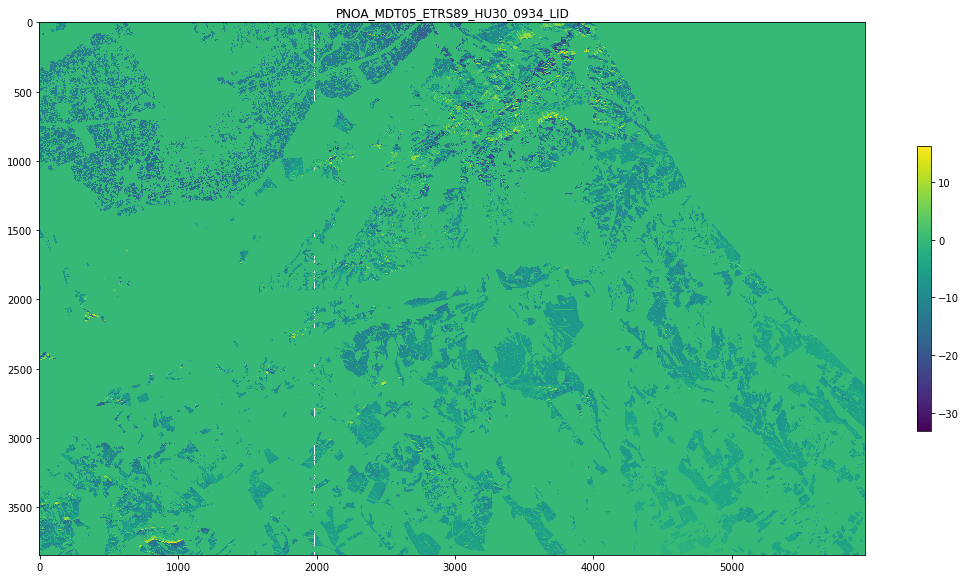

In [97]:
from matplotlib import pyplot as plt

tile = tiles[0]

fig, ax = plt.subplots()

obj = cloud_storage.get_object(bucket=BUCKET, key=f'etc/{tile}_ETC.tif', stream=True)

with rasterio.open(obj) as src:
    arr = src.read(1, out_shape=(src.height, src.width))
    ax.set_title(tile)
    img = ax.imshow(arr)
    fig.colorbar(img, shrink=0.5)

fig.set_size_inches(18.5, 10.5)
plt.show()